# Logistic Classification

This lab details the logistic classification method.


_Warning:_ Logistic classification is actually called ["logistic
regression"](https://en.wikipedia.org/wiki/Logistic_regression) in the literature, but it is in fact a classification method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(25)

The following function will be useful to us.

In [2]:
def find(x): return np.nonzero(x)[0]

Two Classes Logistic Classification
-----------------------------------
Logistic classification is, with [support vector machine (SVM)](https://en.wikipedia.org/wiki/Support_vector_machine), the baseline
method to perform classification. Its main advantage over SVM is that is
is a smooth minimization problem, and that it also outputs class
probability, providing a probabilistic interpretation of the classification.


To understand the behavior of the method, we generate synthetic data
distributed according to a mixture of Gaussian with an overlap governed by an offset $\omega$.
 Here classes indexes are set to $y_i \in
\{-1,1\}$ to simplify the equations.

In [3]:
n = 1000 # number of samples
p = 2 # dimension of the data
omega = np.array([1, .5]) * 2.5 # offset 
n1 = n // 2
X = np.vstack((np.random.randn(n1, p), np.random.randn(n1, p) + np.ones([n1, 2]) * omega))
y = np.vstack((np.ones([n1, 1]), - np.ones([n1, 1])))

Plot the classes.

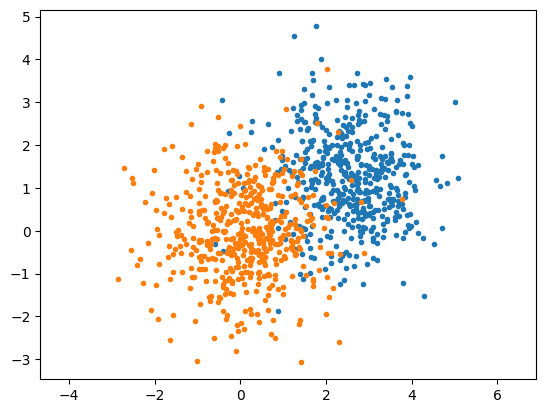

In [4]:
I = find(y == -1)
J = find(y == 1)
plt.plot(X[I, 0], X[I, 1], '.')
plt.plot(X[J, 0], X[J, 1], '.')
plt.axis('equal')
plt.show()

Logistic classification minimizes a logistic loss instead of the usual
$\ell^2$ loss for regression
  $$ \min{w} E(w) := \frac{1}{n} \sum_{i=1}^n L(\langle x_i, w\rangle,y_i)  $$
where the logistic loss reads
  $$ L( s,y ) := \log( 1+\exp(-sy) ) $$
This corresponds to a smooth convex minimization problem. If $X$ is injective,
this is also strictly convex, hence it has a single global minimum.


Let us compare the binary (ideal) 0-1 loss, the logistic loss and the hinge loss (used in SVMs).

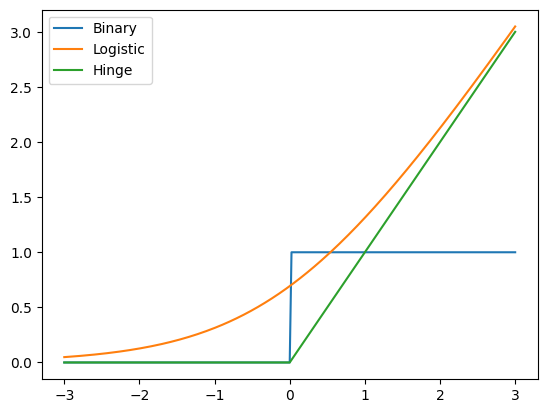

In [5]:
t = np.linspace(-3, 3, 255)
plt.plot(t, t > 0)
plt.plot(t, np.log(1 + np.exp(t)))
plt.plot(t, np.maximum(t, 0))
plt.axis('tight')
plt.legend(['Binary', 'Logistic', 'Hinge'])
plt.show()

This can be interpreted as a [maximum likelihood estimator](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) when one
models the probability of  belonging to the two classes for sample $x_i$ as
  $$ h(x_i) := (\theta(x_i),1-\theta(x_i)) \quad\text{where}\quad
          \theta(s) := \frac{e^{s}}{1+e^s} = (1+e^{-s})^{-1}. $$


Re-writing the energy to minimize
  $$ E(w) = \mathcal{L}(X w,y) \quad\text{where}\quad \mathcal{L}(s,y)= \frac{1}{n}  \sum_i L(s_i,y_i) $$
with $L( s,y ) := \log( 1+\exp(-sy) )$, its gradient reads
  $$ \nabla E(w) = X^\top \nabla \mathcal{L}(X w,y)
      \quad\text{where}\quad
      \nabla \mathcal{L}(s,y) = \frac{y}{n} \odot \theta(-y \odot s),   $$
where $\odot$ is the pointwise multiplication operator, i.e. `*` in
Python.


Define the energies.

In [6]:
def L(s, y): 
    return 1 / n * sum(np.log(1 + np.exp(-s * y)))

def E(w, X, y):
    return L(X.dot(w), y)

Define their gradients.

In [7]:
def theta(v): 
    return 1 / (1 + np.exp(-v))

def nablaL(s,r): 
    return - 1 / n * y * theta(-s * y)

def nablaE(w, X, y): 
    return X.transpose().dot(nablaL(X.dot(w),y))

_Important:_ in order to improve performance, it is important (especially
in low dimension $p$) to add a constant bias term $w_{p+1} \in \mathbb{R}$, and replace $\langle x_i, w\rangle$
by $ \langle x_i, w\rangle + w_{p+1} $.  This is equivalently achieved by
adding an extra $(p+1)^{\text{th}}$ dimension equal to 1 to each
$x_i$, which we do using a convenient macro.

In [8]:
def AddBias(X):
    return np.hstack((X, np.ones((np.size(X, 0), 1))))

With this added bias term, we initialize at $w_{0} \in \mathbb{R}^{p+1}$
(for instance equal to $0_{p+1}$).

In [9]:
w = np.zeros((p+1, 1))

One step of gradient descent reads
$$ w_{\ell+1} = w_\ell - \tau_\ell \nabla E(w_\ell). $$

In [10]:
tau = 1 # here we are using a fixed tau
w = w - tau * nablaE(w, AddBias(X), y)

We should choose $\tau < \frac{2}{L}$ with $ L \leq \frac{1}{4}\|X\|^2 $ to have convergence of the gradient descent, i.e.
$$\tau < \tau_{\max} := \frac{2}{\frac{1}{4}\|X\|^2}.$$

In [11]:
tau_max = 2 / (1 / 4 * np.linalg.norm(AddBias(X), 2) ** 2)
print(tau_max)

0.0014834205153396484


**Question 1:**

Implement a gradient descent
$$ w_{\ell+1} = w_\ell - \tau_\ell \nabla E(w_\ell). $$
Plot the energy decay.

In [12]:
niter = 1000
Elist = np.zeros([niter, 1])
w = np.zeros((p + 1, 1)) # initialization
for i in np.arange(0, niter):
    w = w - tau * nablaE(w, AddBias(X), y)
    Elist[i] = E(w, AddBias(X), y)

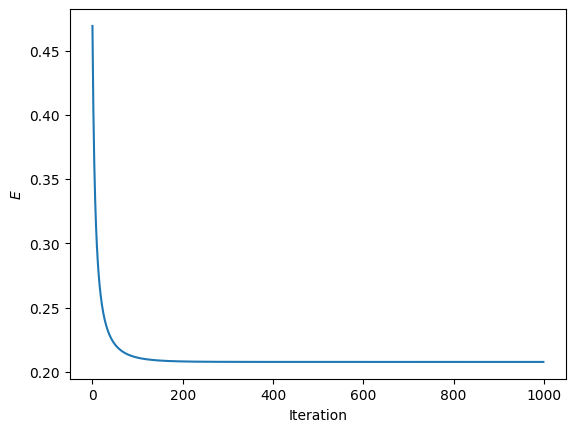

In [13]:
f, ax = plt.subplots()
ax.plot(np.arange(0, niter), Elist[0:niter])
ax.set_ylabel(r'$E$')
ax.set_xlabel('Iteration')
plt.show()

In [14]:
print(w)

[[-2.45336116]
 [-1.08926404]
 [ 3.93427341]]


We want to represent the two regions of the obtained classifier. We first generate a 2D grid of points.

In [15]:
q = 201
tx = np.linspace(X[:, 0].min(), X[:, 0].max(), num=q) 
ty = np.linspace(X[:, 1].min(), X[:, 1].max(), num=q) 
[A, B] = np.meshgrid(tx, ty)
G = np.vstack([A.flatten(), B.flatten()])

We evaluate class probability associated to weight vectors on this grid.

In [16]:
Theta = theta(AddBias(G.T).dot(w))
Theta = Theta.reshape((q, q))

We display the data overlaid on top of the
classification probability. This highlights the
separating hyperplane $ \{x:\langle w,x\rangle=0\} $.

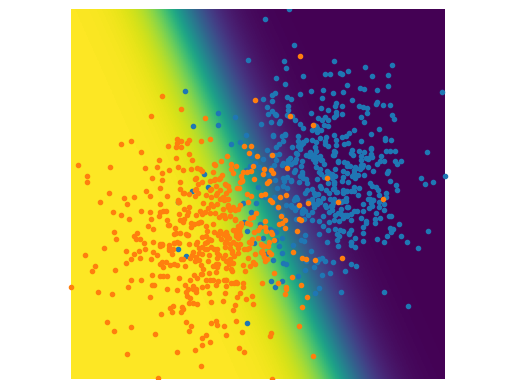

In [17]:
plt.imshow(Theta, origin="lower",  extent=[tx.min(), tx.max(), ty.min(), ty.max()])
plt.axis('equal')
plt.plot(X[I, 0], X[I, 1], '.')
plt.plot(X[J, 0], X[J, 1], '.')
plt.axis('off')
plt.show()

__Exercise 2__

Test the influence of the separation offset $\omega$ on the result.

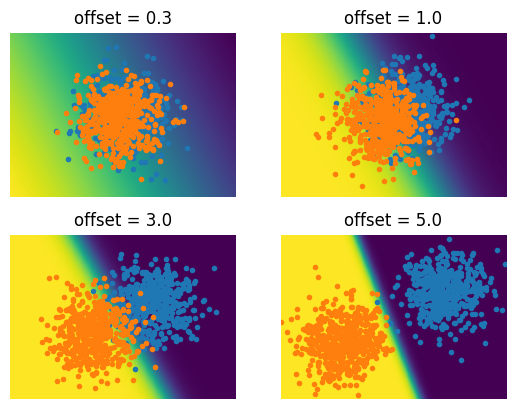

In [18]:
a = 5.5
b = 4
tx = np.linspace(-a, a, num=q)
ty = np.linspace(-b, b, num=q)
[A, B] = np.meshgrid(tx, ty)
G = np.vstack([A.flatten(), B.flatten()])

offs = np.array([0.3, 1, 3, 5])
niter = 10000

for io in np.arange(0, np.size(offs)):
    # generate data
    omega = offs[io] * np.array([1, .5])
    X = np.vstack((np.random.randn(n1, 2)-np.ones([n1, 1])*omega / 2, np.random.randn(n1, 2)+np.ones([n1, 1])*omega / 2))
    # run gradient descent
    w = np.zeros((p + 1, 1))  # initialization
    for i in np.arange(0, niter):
        w = w - tau * nablaE(w, AddBias(X), y)
    # plot
    Theta = theta(AddBias(G.T).dot(w))
    Theta = Theta.reshape((q, q))
    plt.subplot(2, 2, io + 1)
    plt.imshow(Theta, origin="lower",  extent=[-a, a, -b, b])
    plt.axis('equal')
    plt.plot(X[I,0], X[I,1], '.')
    plt.plot(X[J,0], X[J,1], '.')
    plt.axis('off')
    plt.title('offset = ' + str(offs[io]))
    plt.axis([-a, a, -b, b])
plt.show()

Kernelized Logistic Classification
----------------------------------
Logistic classification tries to separate the classes using
a linear separating hyperplane $ \{x :\langle w, x\rangle=0\}. $


In order to generate a non-linear decision boundary, one can replace the
parametric linear model by a non-linear [non-parametric](https://en.wikipedia.org/wiki/Nonparametric_statistics) model, thanks to
kernelization. It is non-parametric in the sense that the number of
parameters grows with the number $n$ of samples (while for the basic
method, the number of parameter is fixed, equal to $p$). This allows in particular to
generate decision boundaries of arbitrary complexity.

The downside is that the numerical complexity of the method grows
(at least) quadratically with $n$.


The good news however is that thanks to the theory of
 [reproducing kernel Hilbert spaces](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)
(RKHS), one can still compute this non-linear decision
function using (almost) the same numerical algorithm.


Given a kernel $ \kappa(x,z) \in \mathbb{R} $ defined for $x,z \in \mathbb{R}^p$,
the kernelized method replaces the linear decision functional $f(x) =
\langle x, w\rangle$ by a sum of kernels centered on the samples
$$ f_h(x) = \sum_{i=1}^n h_i \kappa(x_i,x) $$
where $h \in \mathbb{R}^n$ is a trainable vector of weights.


When using the linear kernel $\kappa(x,y)=\langle x, y\rangle$, one retrieves
the previously studied linear method.


Let us define a macro to compute the pairwise squared Euclidean distance matrix.

In [19]:
# slow
def distmat1(X, Z):
    D = np.zeros((X.shape[0], Z.shape[0]))
    for i in np.arange(0, X.shape[0]):
        for j in np.arange(0, Z.shape[0]):
            D[i,j] = np.linalg.norm(X[i, :] - Z[j, :])
    return D

In [20]:
# fast
from scipy import spatial
def distmat(X,Z): return spatial.distance.cdist(X,Z) ** 2

The gaussian kernel is the best-known and used kernel
$$ \kappa(x,y) := e^{-\frac{\|x-y\|^2}{2\sigma^2}} . $$
The bandwidth parameter $\sigma>0$ is crucial and controls the locality of
the model. It is typically tuned through cross validation.

In [21]:
def kappa(X, Z, sigma): return np.exp(-distmat(X, Z) / (2 * sigma ** 2))

We generate synthetic data in 2-D which are not separable by an
hyperplane.

In [22]:
n = 1000
p = 2
t = 2 * np.pi * np.random.randn(n1, 1)
R = 2.5
r = R * (1.5 + .2 * np.random.randn(n1, 1)) # radius
X1 = np.hstack((np.cos(t) * r, np.sin(t) * r))
X = np.vstack((np.random.randn(n1, 2), X1))
y = np.vstack((np.ones([n1, 1]), -np.ones([n1, 1])))

Display the classes.

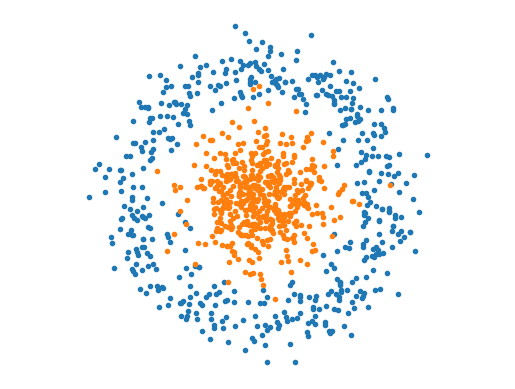

In [23]:
I = find(y == -1)
J = find(y == 1)
plt.plot(X[I, 0], X[I, 1], '.')
plt.plot(X[J, 0], X[J, 1], '.')
plt.axis('equal')
plt.axis('off')
plt.show()

Once evaluated on grid points, the kernel defines a matrix
$$ K = (\kappa(x_i,x_j))_{i,j=1}^n \in \mathbb{R}^{n \times n}.  $$

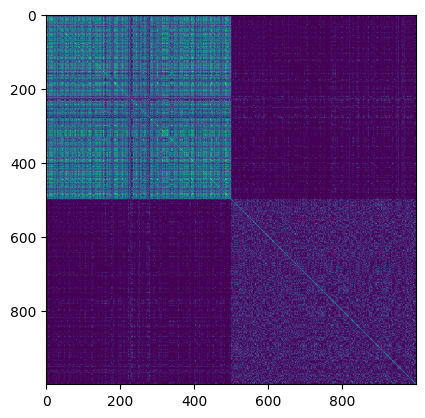

In [24]:
sigma = 1
K = kappa(X, X, sigma)
plt.imshow(K)

Valid kernels are those that are associated with positive symmetric matrices
$K$. The linear and Gaussian kernels are valid kernel functions. Other
popular kernels include the polynomial kernel $ \langle x, y\rangle^a $ for $a
\geq 1$ and the Laplacian kernel $ \exp( -\|x-y\|^2/\sigma ) $.


The kernelized Logistic minimization reads
  $$ \min{h} F(h) := \mathcal{L}(K h,y). $$

In [25]:
def F(h, K, y): return L(K.dot(h), y)
def nablaF(h, K, y): return K.transpose().dot(nablaL(K.dot(h), y))

This minimization can be related to an infinite-dimensional optimization
problem where one minimizes directly over the function $f$. This
is shown to be equivalent to the above finite-dimensional optimization problem
thanks to the theory of RKHS.

**Question 4:**
Implement a gradient descent to minimize $F(h)$.
Monitor the energy decay.

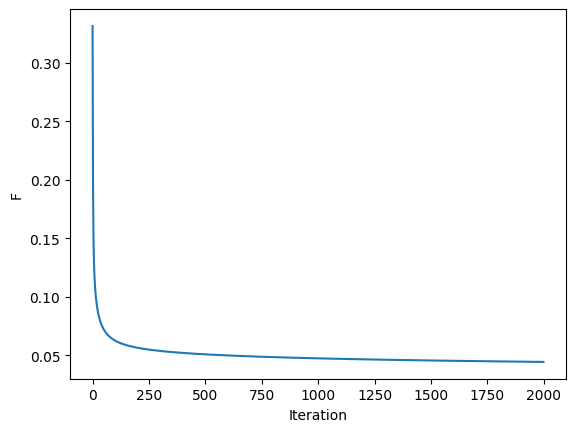

In [26]:
niter = 2000
Flist = np.zeros([niter, 1])
tau = .5
h = np.zeros([n, 1])
for i in np.arange(0, niter):
    h = h - tau * nablaF(h, K, y)
    Flist[i] = F(h, K, y)

plt.plot(np.arange(0, niter), Flist)
plt.axis('tight')
plt.xlabel('Iteration')
plt.ylabel('F')
plt.show()

Once this optimal $h$ has been found, class probabilities at a point
$x$ are obtained as
  $$ (\theta(f_h(x)), 1-\theta(f_h(x)) $$
where $f_h$ has been defined above.


We evaluate this classification probability on a grid as above.

In [27]:
q = 201
tmax = 5
t = np.linspace(-tmax, tmax, num=q)
[A, B] = np.meshgrid(t, t)
G = np.vstack([A.flatten(), B.flatten()])
K1 = kappa(G.T, X, sigma)
Theta = theta(K1.dot(h))
Theta = Theta.reshape((q, q))

Display the classification probability.

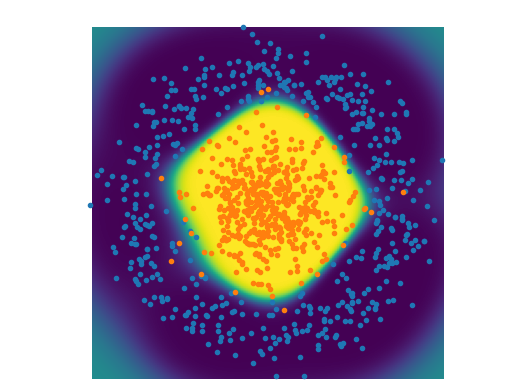

In [28]:
plt.imshow(Theta, origin="lower",  extent=[-tmax, tmax, -tmax, tmax])
plt.plot(X[I,0], X[I,1], '.')
plt.plot(X[J,0], X[J,1], '.')
plt.axis('equal')
plt.axis('off')
plt.show()

**Question 5:**
Display the evolution of the classification probability with $\sigma$

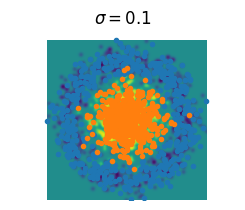

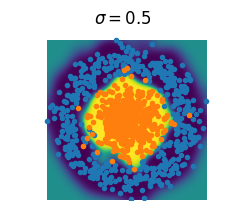

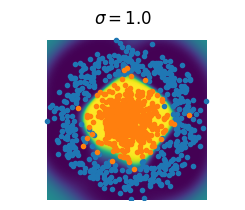

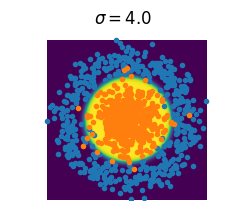

In [29]:
sigma_list = np.array([.1, .5, 1, 4])
niter = 4000

for io in np.arange(0, np.size(sigma_list)):
    sigma = sigma_list[io]
    # grad descent
    K = kappa(X, X, sigma)
    tau = .5
    if io == 4:
        tau = .05
    h = np.zeros((n, 1))
    for i in np.arange(0, niter):
        h = h - tau * nablaF(h, K, y)
    # evaluate on a grid
    K1 = kappa(G.T, X, sigma)
    Theta = theta( K1.dot(h) )
    Theta = Theta.reshape((q, q))
    # Display the classification probability.
    plt.subplot(2, 2, io + 1)
    plt.imshow(Theta.transpose(), origin="lower",  extent=[-tmax, tmax, -tmax, tmax])
    plt.plot(X[I, 0], X[I, 1], '.')
    plt.plot(X[J, 0], X[J, 1], '.')
    plt.axis('equal')
    plt.axis('off')
    plt.title('$\sigma=' + str(sigma) + '$')
    plt.show()

**Question 6:**
Separate the dataset into a training set and a testing set. Evaluate the classification performance
for varying $\sigma$. Try to introduce regularization and minimize
$$ \min{h} F(h) := \mathcal{L}(K h,y) + \lambda R(h) $$
where for instance $R=\|\cdot\|_2^2$ or  $R=\|\cdot\|_1$.